In [19]:
import numpy as np
import pandas as pd
import pylab as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

# Step 1: Generate Synthetic Data

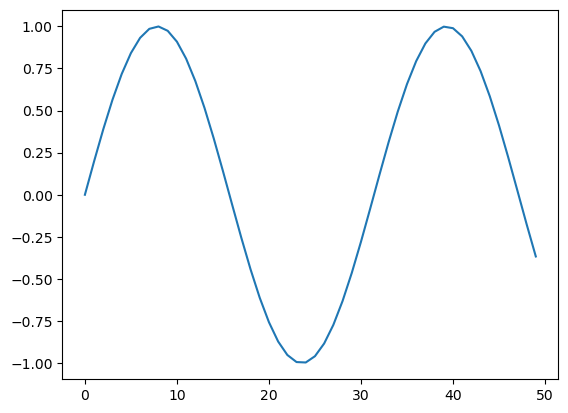

In [2]:
plt.plot(np.sin(np.arange(50)/5))

In [3]:
def generate_sequences(n_samples, seq_length, complexity_factor):
    X = []
    y = []
    for _ in range(n_samples):
        seq = np.zeros(seq_length)
        # label_ = np.random.randint(2)
        label_ = int(2*_/n_samples)
        if label_==0:
            seq[:seq_length//2] = 1
            y.append(0)
        else:
            seq[-seq_length//2:] = 1
            y.append(1)
        noise = np.random.normal(0,0.5*complexity_factor,seq_length)
        seq = seq+noise
        X.append(seq)
    return np.array(X), np.array(y)


### Parameters to Generate data

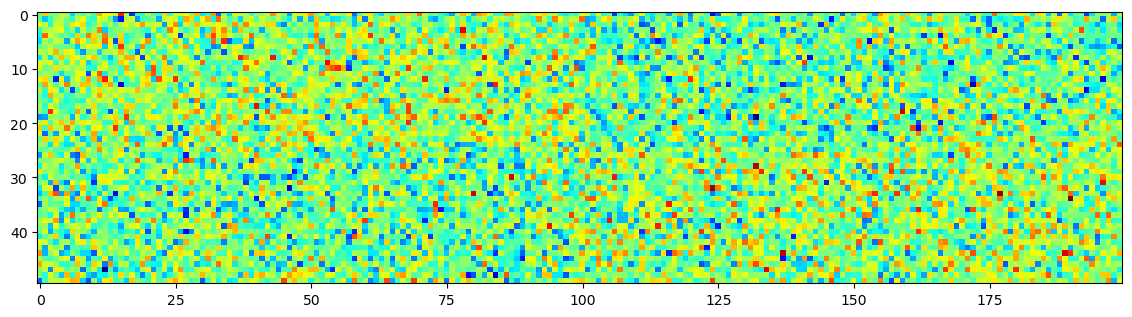

In [4]:

n_samples = 200
seq_length = 50
complexity_factor = 5

X, y = generate_sequences(n_samples, seq_length, complexity_factor)

plt.subplots(1,1,figsize=(14,6))
plt.imshow(X.T,cmap='jet')

# Step 2: Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train Classifiers

### Logistic Regression

In [6]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print( 'Accuracy: ', accuracy_score(y_test, y_pred))
print( 'F1 score: ', f1_score(y_test, y_pred))
print( 'Precision: ', precision_score(y_test, y_pred))
print( 'Recall: ', recall_score(y_test, y_pred))

Accuracy:  0.8333333333333334
F1 score:  0.8275862068965517
Precision:  0.8275862068965517
Recall:  0.8275862068965517


### Random Forest

In [7]:
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train)
y_pred = rand_forest.predict(X_test)

print( 'Accuracy: ', accuracy_score(y_test, y_pred))
print( 'F1 score: ', f1_score(y_test, y_pred))
print( 'Precision: ', precision_score(y_test, y_pred))
print( 'Recall: ', recall_score(y_test, y_pred))

Accuracy:  0.8
F1 score:  0.7857142857142857
Precision:  0.8148148148148148
Recall:  0.7586206896551724


# Step 4: Evaluate Models with Different Splits

In [8]:
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Iteration {i+1} - Logistic Regression Accuracy: {accuracy}")

Iteration 1 - Logistic Regression Accuracy: 0.8
Iteration 2 - Logistic Regression Accuracy: 0.7166666666666667
Iteration 3 - Logistic Regression Accuracy: 0.8333333333333334
Iteration 4 - Logistic Regression Accuracy: 0.6833333333333333
Iteration 5 - Logistic Regression Accuracy: 0.85


In [9]:
# Step 5: Cross-Validation
log_reg_cv_scores = cross_val_score(log_reg, X, y, cv=5)
rand_forest_cv_scores = cross_val_score(rand_forest, X, y, cv=5)

print(f"Logistic Regression CV Accuracy: {np.mean(log_reg_cv_scores):2.2f} ({np.std(log_reg_cv_scores):2.2f})")
print(f"Random Forest CV Accuracy: {np.mean(rand_forest_cv_scores):2.2f} ({np.std(log_reg_cv_scores):2.2f})")

Logistic Regression CV Accuracy: 0.82 (0.04)
Random Forest CV Accuracy: 0.81 (0.04)


# Pubmed RCT 200k data

In [10]:
from datasets import load_dataset

In [11]:
dataset_pubmed = load_dataset('nanyy1025/pubmed_rct_200k')
dataset_pubmed

DatasetDict({
    train: Dataset({
        features: ['target', 'pubmed_id', 'text_combined', 'text'],
        num_rows: 190654
    })
})

In [12]:
texts = dataset_pubmed['train']['text']
targets = dataset_pubmed['train']['target']
X_text = []
y_raw = []
for i_ in range(len(targets)):
    X_text.extend(texts[i])
    y_raw.extend(targets[i])

In [50]:
X_text[:2]

array(['topical formulations of nonsteroidal anti-inflammatory drugs ( nsaids ) are generally considered to be safer alternatives to oral nsaids due to lower systemic absorption .',
       'we conducted randomized , crossover studies that compared the pharmacokinetics ( pk ) , bioequivalence and safety of topical diclofenac sodium @ % twice daily ( bid ) , diclofenac sodium @ % four times daily ( qid ) and oral diclofenac sodium in healthy subjects .'],
      dtype='<U264')

In [51]:
y_raw[:2]

['BACKGROUND', 'BACKGROUND']

In [13]:
categories,counts = np.unique(y_raw, return_counts=1)
categories,counts

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'RESULTS'], dtype='<U11'),
 array([381308, 571962, 762616, 953270]))

In [14]:
label_mapping = {category: idx for idx, category in enumerate(categories)}
label_mapping

{'BACKGROUND': 0, 'CONCLUSIONS': 1, 'METHODS': 2, 'RESULTS': 3}

In [15]:
y = np.array([label_mapping[label] for label in y_raw])
np.unique(y, return_counts=1)

(array([0, 1, 2, 3]), array([381308, 571962, 762616, 953270]))

In [16]:
X_text = np.array(X_text)
y = np.array(y)

In [17]:
# Select a subset of each label randomly with the same size
selected_indices = []
for label in [0,1,2,3]:
    label_indices = np.where(y == label)[0]
    selected_indices.extend(np.random.choice(label_indices, 500, replace=False))

# Subset the data
X_text_subset = X_text[selected_indices]
y_subset = y[selected_indices]

# Embedding

In [20]:
import torch
from transformers import AutoModel

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = AutoModel.from_pretrained("jinaai/jina-embeddings-v3", trust_remote_code=True).to(device)

texts = [
    "Follow the white rabbit.",  # English
    "Sigue al conejo blanco.",  # Spanish
    "Suis le lapin blanc.",  # French
    "跟着白兔走。",  # Chinese
    "اتبع الأرنب الأبيض.",  # Arabic
    "Folge dem weißen Kaninchen.",  # German
]

# When calling the `encode` function, you can choose a `task` based on the use case:
# 'retrieval.query', 'retrieval.passage', 'separation', 'classification', 'text-matching'
# Alternatively, you can choose not to pass a `task`, and no specific LoRA adapter will be used.
embeddings = model.encode(texts, task="text-matching")

# Compute similarities
print(embeddings[0] @ embeddings[1].T)

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

0.7106418


In [21]:
X_subset = []
for i_ in tqdm(    range(len(X_text_subset))    ):
    text_ = model.encode(X_text_subset[i], task="classification")
    X_subset.append(text_)
X_subset = np.array(X_subset)

100%|███████████████████████████████████████████████████████| 2000/2000 [04:58<00:00,  6.70it/s]


In [22]:
X_subset.shape,y_subset.shape

((2000, 1024), (2000,))

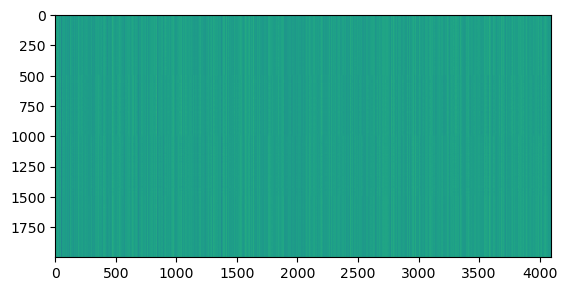

In [52]:
plt.imshow(X_subset)

In [53]:
X_subset[0]

tensor([-0.0063,  0.0054,  0.0173,  ..., -0.0115,  0.0144, -0.0181])

In [23]:
# Step 5: Cross-Validation
log_reg_cv_scores = cross_val_score(log_reg, X_subset, y_subset, cv=5)
rand_forest_cv_scores = cross_val_score(rand_forest, X_subset, y_subset, cv=5)

print(f"Logistic Regression CV Accuracy: {np.mean(log_reg_cv_scores):2.2f} ({np.std(log_reg_cv_scores):2.2f})")
print(f"Random Forest CV Accuracy: {np.mean(rand_forest_cv_scores):2.2f} ({np.std(log_reg_cv_scores):2.2f})")

Logistic Regression CV Accuracy: 0.25 (0.00)
Random Forest CV Accuracy: 0.25 (0.00)


In [38]:
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import numpy as np

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Function to get sentence embeddings
def get_embeddings(sentences):
    inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings

# Embed the sentences
X_subset = get_embeddings(list(X_text_subset))

# Reduce dimensionality with PCA
pca = PCA(n_components=64)  # Adjust n_components as needed
X_subset = pca.fit_transform(X_subset)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred, target_names=['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'RESULTS']))

              precision    recall  f1-score   support

  BACKGROUND       1.00      1.00      1.00       104
 CONCLUSIONS       0.28      0.37      0.32        95
     METHODS       0.21      0.24      0.22        88
     RESULTS       0.32      0.20      0.25       113

    accuracy                           0.46       400
   macro avg       0.45      0.45      0.45       400
weighted avg       0.46      0.46      0.46       400



In [39]:
X_subset.shape, y_subset.shape

((2000, 2), (2000,))

In [40]:
# !pip install umap-learn -q

/home/asadr/miniconda3/envs/hf/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'UMAP')

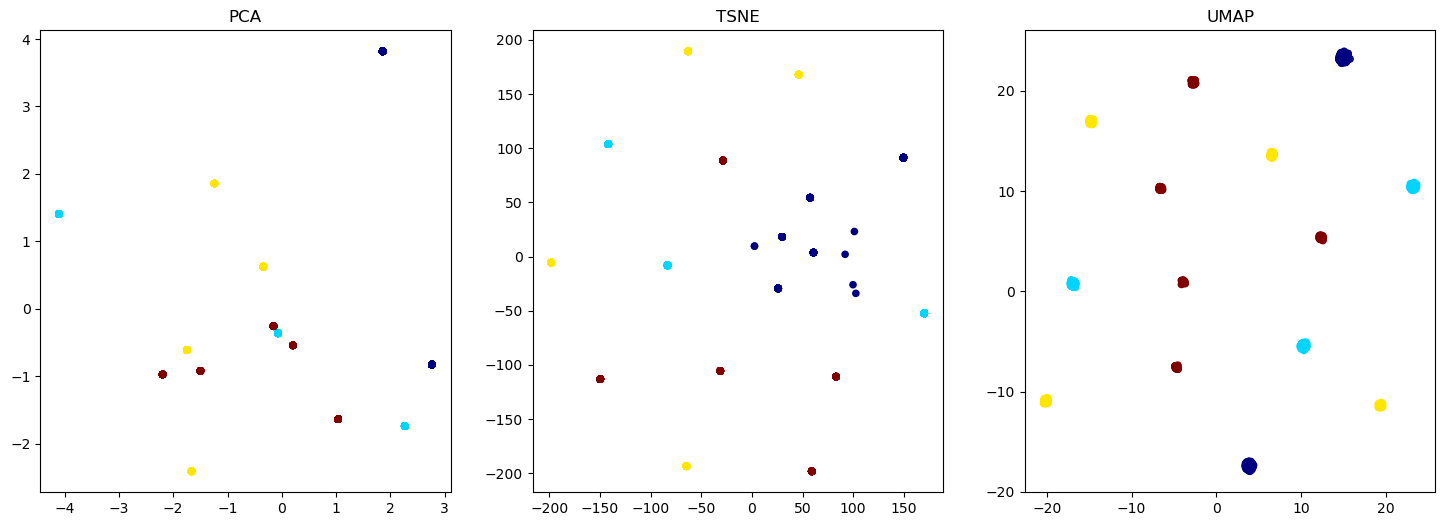

In [41]:
from sklearn.manifold import TSNE
import umap

# Reduce dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_subset)

# Reduce dimensions using TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_subset)

# Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_subset)

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PCA plot
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_subset, cmap='jet', s=20)
axes[0].set_title('PCA')

# TSNE plot
axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset, cmap='jet', s=20)
axes[1].set_title('TSNE')

# UMAP plot
axes[2].scatter(X_umap[:, 0], X_umap[:, 1], c=y_subset, cmap='jet', s=20)
axes[2].set_title('UMAP')

In [46]:
import os
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

# Each query needs to be accompanied by an corresponding instruction describing the task.
query_prefix = "What type of text is it: a- BACKGROUND, b-CONCLUSIONS, c-METHODS, d-RESULTS \nQuery: "

# load model with tokenizer
model = AutoModel.from_pretrained('nvidia/NV-Embed-v1', trust_remote_code=True)

# get the embeddings
max_length = 768
X_subset = model.encode(list(X_text_subset), instruction=query_prefix, max_length=max_length)

# Reduce dimensionality with PCA
pca = PCA(n_components=8)  # Adjust n_components as needed
X_subset = pca.fit_transform(X_subset)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred, target_names=['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'RESULTS']))

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

  BACKGROUND       1.00      1.00      1.00       104
 CONCLUSIONS       1.00      1.00      1.00        95
     METHODS       1.00      1.00      1.00        88
     RESULTS       1.00      1.00      1.00       113

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [47]:
X_subset.shape, y_subset.shape

((2000, 8), (2000,))

/home/asadr/miniconda3/envs/hf/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'UMAP')

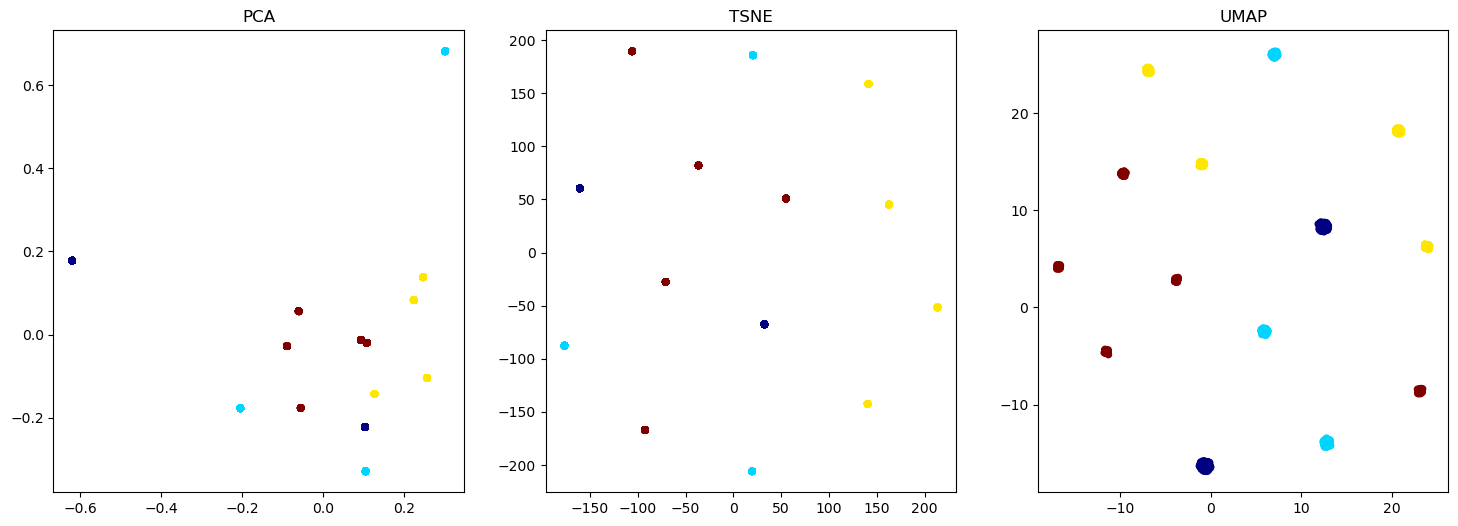

In [48]:
from sklearn.manifold import TSNE
import umap

# Reduce dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_subset)

# Reduce dimensions using TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_subset)

# Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_subset)

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PCA plot
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_subset, cmap='jet', s=20)
axes[0].set_title('PCA')

# TSNE plot
axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset, cmap='jet', s=20)
axes[1].set_title('TSNE')

# UMAP plot
axes[2].scatter(X_umap[:, 0], X_umap[:, 1], c=y_subset, cmap='jet', s=20)
axes[2].set_title('UMAP')

In [49]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Each query needs to be accompanied by an corresponding instruction describing the task.
query_prefix = "how many r is there?"

# load model with tokenizer
model = AutoModel.from_pretrained('nvidia/NV-Embed-v1', trust_remote_code=True)

# get the embeddings
max_length = 8
X_subset = model.encode(list(X_text_subset), instruction=query_prefix, max_length=max_length)

# normalize embeddings
# X_subset = F.normalize(X_subset, p=2, dim=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred, target_names=['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'RESULTS']))

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/home/asadr/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v1/f4478f119ae95d2dbe0692abbf3415db876a1e00/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),


              precision    recall  f1-score   support

  BACKGROUND       1.00      1.00      1.00       104
 CONCLUSIONS       1.00      0.63      0.77        95
     METHODS       1.00      0.80      0.89        88
     RESULTS       0.68      1.00      0.81       113

    accuracy                           0.87       400
   macro avg       0.92      0.86      0.87       400
weighted avg       0.91      0.87      0.87       400



In [4]:
from datasets import load_dataset
dataset_medal = load_dataset("medal")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['abstract_id', 'text', 'location', 'label'],
        num_rows: 3000000
    })
    test: Dataset({
        features: ['abstract_id', 'text', 'location', 'label'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['abstract_id', 'text', 'location', 'label'],
        num_rows: 1000000
    })
    full: Dataset({
        features: ['abstract_id', 'text', 'location', 'label'],
        num_rows: 14393619
    })
})

Generating train split: 0 examples [00:00, ? examples/s]